# Exploiting field-free entanglement

In [40]:
import numpy as np
import QDYN
from notebook_utils import get_zeta_table, plot_zeta_data, filter_table, get_logical_energies_table, get_stage4_table

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
get_zeta_table = QDYN.memoize.memoize(get_zeta_table)
get_zeta_table.load('zeta_table.cache')

In [5]:
zeta_table = get_zeta_table('./runs_050_RWA', T=50)

/Users/goerz/jobs/ConstrainedTransmon/venv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


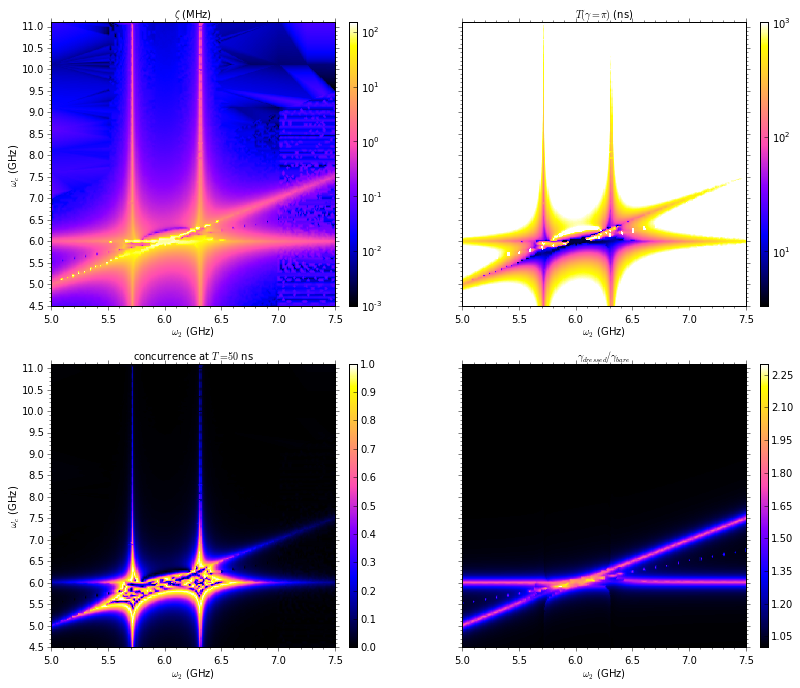

In [6]:
plot_zeta_data(zeta_table, T=50)

We manually choose a number of points that provide large field-free entanglement:

In [7]:
select_points = [ # (w2, wc)
    (5.65, 6.0), (5.7, 5.7), (5.85, 5.85), (6.275, 6.31), (6.3, 6.0),
    (6.15, 6.15), (5.88, 5.9), (5.52, 5.55), (5.523, 5.995), (6.5, 6.025),
    (6.46, 6.45), (6.39, 6.35)
]
select_points_table = filter_table(zeta_table, select_points).copy()
select_points_table['T(pi) [ns]'] = 1000 / (2 * np.abs(select_points_table['zeta [MHz]']))
select_points_table.reset_index(drop=True)
#print(select_points_table.to_string())

,w1 [GHz],w2 [GHz],wc [GHz],zeta [MHz],gamma [MHz],T(pi) [ns]
0,6,5.523,5.995,134.958,0.021571,3.704856
1,6,5.880,5.900,-126.113,0.026238,3.964698
2,6,6.390,6.350,-149.772,0.022503,3.338408
3,6,5.650,6.000,136.538,0.020800,3.661984
4,6,5.520,5.550,115.762,0.019496,4.319207
5,6,6.500,6.025,116.039,0.019516,4.308896
6,6,5.700,5.700,-61.690,0.016838,8.105041
7,6,6.150,6.150,123.534,0.022084,4.047469
8,6,5.850,5.850,-92.894,0.019766,5.382479
9,6,6.460,6.450,134.367,0.021598,3.721152


In [24]:
transition_table = get_logical_energies_table(select_points_table.index, frame='lab')
transition_table['E11 - E10 [MHz]'] = transition_table['E11 [MHz]'] - transition_table['E10 [MHz]']
transition_table['E11 - E01 [MHz]'] = transition_table['E11 [MHz]'] - transition_table['E01 [MHz]']
transition_table.rename(columns={'E01 [MHz]': 'E01 - E00 [MHz]', 'E10 [MHz]': 'E10 - E00 [MHz]'}, inplace=True)
transition_table['bare w2 [MHz]'] = select_points_table['w2 [GHz]'] * 1000.0
transition_table['bare w1 [MHz]'] = select_points_table['w1 [GHz]'] * 1000.0
transition_table.drop('E00 [MHz]', axis=1, inplace=True)
transition_table.drop('E11 [MHz]', axis=1, inplace=True)
transition_table.reset_index(drop=True)

,E01 - E00 [MHz],E10 - E00 [MHz],E11 - E10 [MHz],E11 - E01 [MHz],bare w2 [MHz],bare w1 [MHz]
0,5513.510,5933.742,5648.468,6068.700,5523,6000
1,5929.497,6043.266,5803.384,5917.153,5880,6000
2,6446.970,5986.072,6297.198,5836.300,6390,6000
3,5636.020,5937.992,5772.558,6074.530,5650,6000
4,5459.690,6010.868,5575.452,6126.630,5520,6000
5,6510.300,5937.671,6626.339,6053.710,6500,6000
6,5760.510,6016.290,5698.820,5954.600,5700,6000
7,6100.290,5968.326,6223.824,6091.860,6150,6000
8,5899.710,6031.674,5806.816,5938.780,5850,6000
9,6391.250,5989.123,6525.617,6123.490,6460,6000


Any of the above frequencies are conceivable to drive single-qubit gates

In [37]:
def write_params(outfile, wd_strategy, select_points_table, transition_table):
    with open(outfile, 'w') as out_fh:
        out_fh.write("#%11s%12s%12s%12s%10s\n"
            % ('w2 [GHz]', 'wc [GHz]', 'wd [GHz]', 'T [ns]', 'target'))
        for rf in select_points_table.index:
            w2 = select_points_table.loc[rf]['w2 [GHz]']
            wc = select_points_table.loc[rf]['wc [GHz]']
            T = 2 *  select_points_table.loc[rf]['T(pi) [ns]']
            for target in ['H_left', 'H_right', 'Ph_left', 'Ph_right']:
                if wd_strategy == 'bare':
                    if 'left' in target:
                        wd = float(transition_table.loc[rf]['bare w1 [MHz]']) / 1000.0
                    else:
                        wd = float(transition_table.loc[rf]['bare w2 [MHz]']) / 1000.0
                elif wd_strategy == 'dressed0':
                    if 'left' in target:
                        wd = float(transition_table.loc[rf]['E10 - E00 [MHz]']) / 1000.0
                    else:
                        wd = float(transition_table.loc[rf]['E01 - E00 [MHz]']) / 1000.0
                elif wd_strategy == 'dressed1':
                    if 'left' in target:
                        wd = float(transition_table.loc[rf]['E11 - E01 [MHz]']) / 1000.0
                    else:
                        wd = float(transition_table.loc[rf]['E11 - E10 [MHz]']) / 1000.0
                else:
                    raise ValueError("Unkown wd_strategy: %s" % wd_strategy)
                out_fh.write("%12.8f%12.8f%12.8f%12.8f%10s\n" % (w2, wc, wd, T, target))
        

In [38]:
write_params("zeta_oct_params_zero_bare.dat", wd_strategy='bare',
             select_points_table=select_points_table, transition_table=transition_table)
write_params("zeta_oct_params_zero_dressed0.dat", wd_strategy='dressed0',
             select_points_table=select_points_table, transition_table=transition_table)
write_params("zeta_oct_params_zero_dressed1.dat", wd_strategy='dressed1',
             select_points_table=select_points_table, transition_table=transition_table)

The actual calculations are done in the index notebook

In [ ]:
get_stage4_table("runs_zeta_oct", stage_folder='universal_bare')

In [ ]:
get_stage4_table("runs_zeta_oct", stage_folder='universal_dressed0')

In [ ]:
get_stage4_table("runs_zeta_oct", stage_folder='universal_dressed1')